## [미니프로젝트] 서울시 공유자전거 '따릉이'의 수요 예측

### 여러분은 서울시 정책 연구원으로써 서울시 공유자전거인 '따릉이'의 수요와 날씨간 연관성을 분석하라는 미션을 부여받았습니다.

#### <font color="blue"> 데이터 분석의 주 목적은 가치있는 정보를 찾아내는것!! </font>

### ▣ 우리가 풀어야 하는 문제는 무엇인가요?

 - 기상상황이 따릉이 수요에 주는 영향을 분석해봅시다.

---

## ▣ 데이터 소개
[기본 데이터]
* 학습데이터 : traindata.csv

## ▣ 데이터셋의 변수 소개
* date : 날짜
* hour : 시간
* temperature : 온도
* precipitation : 강우 여부, 비가 오지 않았으면 0, 비가 오면 1
* windspeed : 풍속(평균)
* humidity : 습도
* visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* ozone : 오존 수치
* PM10 : 미세먼지 수치(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* PM2.5 : 초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count : 시간에 따른 따릉이 대여 수

---

### [과제1] 환경 설정
#### <span style="color: green"> 1) 라이브러리 불러오기 </span>

In [1]:
#EDA에 사용할 라이브러리를 import 하세요
import pandas as pd
import seaborn as sns
import scipy.stats as spst
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings   
warnings.filterwarnings("ignore")

#### <span style="color: green"> 2) 활용할 데이터 불러오기 </span>

In [2]:
df = pd.read_csv('traindata.csv')
df.head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30


In [3]:
df.tail()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
5822,2021-11-29,20,74.0,58.0,0.002,9.3,0,0.3,66,1193,273
5823,2021-11-29,21,65.0,56.0,0.002,8.4,0,2.0,70,1233,228
5824,2021-11-29,22,51.0,41.0,0.002,8.6,0,1.9,70,1250,215
5825,2021-11-29,23,43.0,35.0,0.001,8.2,0,2.1,71,1262,125
5826,2021-11-30,0,39.0,31.0,0.004,7.9,0,2.3,71,1483,95


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5827 entries, 0 to 5826
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           5827 non-null   object 
 1   hour           5827 non-null   int64  
 2   PM10           5725 non-null   float64
 3   PM2.5          5732 non-null   float64
 4   ozone          5699 non-null   float64
 5   temperature    5827 non-null   float64
 6   precipitation  5827 non-null   int64  
 7   windspeed      5827 non-null   float64
 8   humidity       5827 non-null   int64  
 9   visibility     5827 non-null   int64  
 10  count          5827 non-null   int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 500.9+ KB


In [5]:
df_hour = df.groupby('hour', as_index=False)['count'].sum()
df_hour

,hour,count
0,0,22374
1,1,13818
2,2,8562
3,3,5726
4,4,4205
5,5,6859
6,6,16317
7,7,33462
8,8,61533
9,9,45257


In [6]:
df_date = df.groupby('date', as_index=False)['count'].sum()
df_date

,date,count
0,2021-04-01,6116
1,2021-04-02,5799
2,2021-04-03,559
3,2021-04-04,5353
4,2021-04-05,6007
...,...,...
239,2021-11-26,3932
240,2021-11-27,3318
241,2021-11-28,3470
242,2021-11-29,4482


### [과제2] 가설설정
#### '가설' 이란 단어를 생각해보면, 우리가 직접 가설을 만들어야 할것 같지만 통계에서 분석기법별 귀무가설/대립가설은 정해져있습니다.
- 귀무가설은 차이가 없다, 연관성이 없다, 효과가 없다.
- 대립가설은 차이가 있다, 연관성이 있다, 효과가 있다. 라고 간단하게 이해하시면 좋습니다.

#### 간단한 예로, 온도와 따릉이 대여량간 가설을 수립 해본다면

    - 귀무가설 : 온도와 따릉이 간에는 연관성이 없다.
    - 대립가설 : 온도와 따릉이 간에는 연관성이 있다.

로 가설이 자연스레 수립 됩니다.



---


#### <span style="color: green"> 'precipitation' 변수를 포함하여, 최소 5개 이상의 Feature와 따릉이 대여량 간 가설을 수립해주세요. </span>

##### Guide : Target은 따릉이 대여량 입니다.

- 가설 1 : 1시간전 강우 여부와 따릉이간에는 연관성이 없다.
    - 대립가설 : 1시간전 강우 여부와 따릉이 대여량 간에는 연관성이 있다.


- 가설 2 : 미세먼지수치/초미세먼지수치와 따릉이간에는 연관성이 없다 / 있다
    - 미세먼지수치 > 초미세먼지수치간 관계가 있을 것이다.
 
 
- 가설 3: 온도와 따릉이간에는 연관성이 없다 / 있다
    - 특히 온도가 높아질수록 대여량이 줄어들 것이다 (음의 상관관계)
    - 단, 온도가 아주 낮으면 대여량이 다시 줄어들 것이다?
    
    
- 가설 4: 풍속과 따릉이간에는 연관성이 없다 / 있다


- 가설 5: 습도와 따릉이간에는 연관성이 없다 / 있다
    - 대한민국의 평균 습도인 67%를 넘어갔을 때 대여량이 궁금.
    
    
- 가설 6: 가시거리와 따릉이간에는 연관성이 없다 / 있다
    - 사실, 큰 차이 없을 것 같음.
    
    
- 가설 7: 오존과 따릉이간에는 연관성이 없다 / 있다
    - 사람들이 오존 수치를 체감할 수 있나?

### [과제3] 단변량 분석

단변량 분석은 데이터분석의 매우 기초적인 분석기법으로, 독립적인 개별 변수가 가지고있는 특성들을 이해하는 과정입니다.

<span style="color: green"> 개별 변수에 대해 아래 사항들을 분석해보세요. </span>

1. 변수가 내포하고 있는 의미
2. 변수가 수치형인지, 범주형인지
3. 결측치 존재 여부 및 조치 방안
4. 기초 통계량 확인
5. 데이터 분포 확인
6. 위 정보로부터 파악한 내용 정리
7. 추가 분석사항 도출

### Feature1 : hour

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

- 시간을 의미

2. 변수가 수치형인지 범주형인지


In [8]:
#변수의 자료형을 확인해보세요.
df['hour']

0        1
1        2
2        3
3        4
4        5
        ..
5822    20
5823    21
5824    22
5825    23
5826     0
Name: hour, Length: 5827, dtype: int64

In [9]:
var = 'hour'
temp = df_hour[var]
temp.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

3. 변수의 결측치 존재 여부 및 조치방안

In [11]:
# 변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
df['hour'].isna().sum()

0

4. 변수의 기초 통계량 확인

In [12]:
# 변수의 기초 통계량을 확인해보세요
df['hour'].describe()

count    5827.000000
mean       11.506607
std         6.921963
min         0.000000
25%         6.000000
50%        12.000000
75%        18.000000
max        23.000000
Name: hour, dtype: float64

5. 변수의 분포 확인

In [13]:
df['hour'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23,  0], dtype=int64)

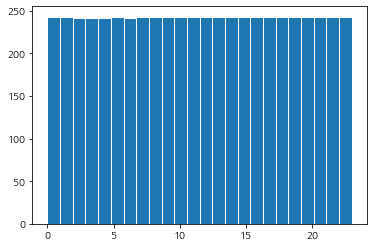

In [14]:
plt.hist(df['hour'], bins = 24, edgecolor = 'white')
plt.show()

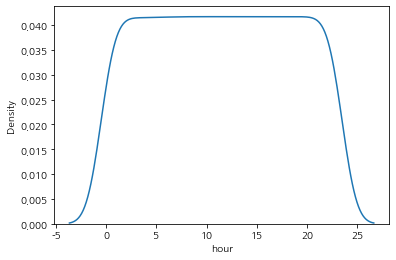

In [16]:
sns.kdeplot(df['hour'])
plt.show()

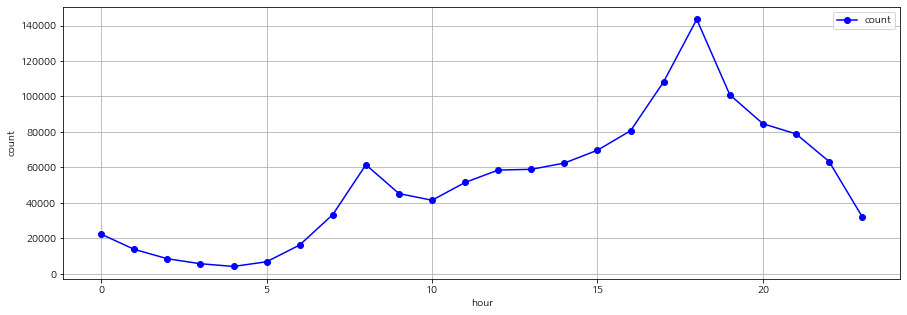

In [17]:
# 변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (15,5))

plt.plot('hour', 'count', 'bo-', data=df_hour, label='count')
plt.xlabel('hour')
plt.ylabel('count')

plt.legend()
plt.grid()
plt.show()

6. 위 정보로 부터 파악한 내용 정리

- 출퇴근 시간대인 8시, 16-20시의 대여량이 많았다.
- 각 시간별로 데이터가 균일하게 분포되어 있음을 알 수 있다.
- 데이터 불균형이 일어나지 않았다.

7. 추가 분석사항 도출

In [18]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Feature2 : temperature

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

- 섭씨온도
- 물이 끓는점을 100℃, 얼음이 녹는점을 0℃로 하여 이 사이를 100등분한 온도 눈금. 

2. 변수가 수치형인지 범주형인지


In [24]:
df['temperature']

0       13.1
1       12.4
2       13.1
3       13.0
4       13.0
        ... 
5822     9.3
5823     8.4
5824     8.6
5825     8.2
5826     7.9
Name: temperature, Length: 5827, dtype: float64

In [25]:
var = 'temperature'
temp = df[var]
temp.unique()

array([13.1, 12.4, 13. , 12.6, 12. , 14. , 16.2, 18.2, 20.2, 21.7, 22.6,
       23.6, 23.2, 23.5, 23. , 22.3, 20.6, 19.2, 18.1, 16.5, 15.4, 14.6,
       14.2, 13.7, 12.9, 12.8, 12.7, 13.6, 17.4, 18.9, 20.7, 21.6, 22. ,
       22.9, 21. , 19.9, 19.4, 19. , 18.8, 18.4, 18. , 17.7, 17.6, 17.3,
       17.5, 16.8, 15.8, 14.9, 14.8, 14.5, 14.4, 14.3, 13.5, 12.5, 11.7,
       11.4, 10.9, 10.5, 10.3, 10.4, 10.2,  9.7,  9.5,  9.6, 10. , 10.7,
       11.6, 14.7, 15.5, 15. , 12.3,  9. ,  8.1,  7.4,  6.8,  6.5,  6.1,
        5.5,  5.4,  7.9, 16.6, 17.9, 15.9, 13.3, 10.6, 10.8,  9.4, 16.1,
       17. , 18.6, 16. , 15.1, 12.1,  8.7,  8.2,  8.3, 16.7, 19.3, 20.4,
       19.7, 13.8, 11.3, 10.1,  8.9,  7.6,  7.2, 13.9, 17.8, 11.2,  8.6,
        7.8,  7.7,  8.8, 17.2, 19.5, 18.5,  9.8,  9.1,  8. , 15.2, 18.3,
       11.8,  8.4, 12.2, 17.1, 20.8, 21.2, 21.5, 16.9, 11. , 11.1, 11.9,
       11.5,  5.7,  5. ,  4.6,  3.9,  3.4,  3.1,  7.1,  6.6,  6.4,  6.7,
        6.9,  7. ,  7.3,  6.2, 13.2,  5.8,  5.6,  8

3. 변수의 결측치 존재 여부 및 조치방안

In [42]:
df['temperature'].isna().sum()

0

4. 변수의 기초 통계량 확인

In [28]:
df['temperature'].describe()

count    5827.000000
mean       19.376798
std         7.501572
min        -3.500000
25%        14.100000
50%        20.400000
75%        24.900000
max        36.300000
Name: temperature, dtype: float64

5. 변수의 분포 확인

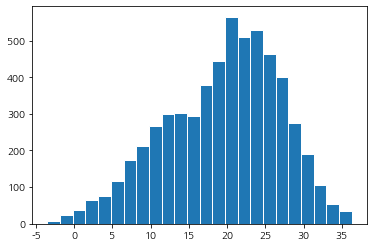

In [29]:
plt.hist(df['temperature'], bins = 24, edgecolor = 'white')
plt.show()

<AxesSubplot:xlabel='temperature', ylabel='Density'>

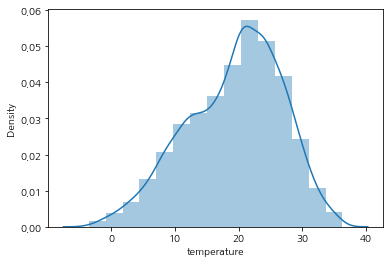

In [30]:
sns.distplot(df['temperature'], bins=15)

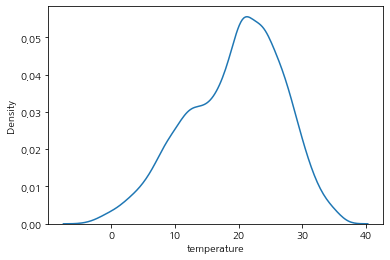

In [31]:
sns.kdeplot(df['temperature'])
plt.show()

6. 위 정보로 부터 파악한 내용 정리

- 평균, 중앙값에 많이 분포해있다.
- 평균이 19.37인데 비해 가장 많은 빈도를 보이는 온도는 20~25도 부근이다.

7. 추가 분석사항 도출

In [32]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

- 온도가 아주 낮거나 아주 높을 때 대여량이 궁금
- 특히 온도가 높아질수록 대여량이 급격하게 줄어드는지? (가설)
- 온도와 습도의 상관관계가 궁금

In [33]:
spst.pearsonr(df['temperature'], df['humidity'])

(-0.09216232432104923, 1.8061337339784914e-12)

### Feature3 : precipitation

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

- 강우 여부. 비가 오지 않았으면 0, 비가 왔으면 1

2. 변수가 수치형인지 범주형인지

In [34]:
df['precipitation']

0       0
1       0
2       0
3       0
4       0
       ..
5822    0
5823    0
5824    0
5825    0
5826    0
Name: precipitation, Length: 5827, dtype: int64

In [39]:
var = 'precipitation'
temp = df[var]
temp.unique()

array([0, 1], dtype=int64)

3. 변수의 결측치 존재 여부 및 조치방안

In [35]:
df['precipitation'].isna().sum()

0

4. 변수의 기초 통계량 확인

In [36]:
df['precipitation'].describe()

count    5827.000000
mean        0.075511
std         0.264236
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: precipitation, dtype: float64

5. 변수의 분포 확인

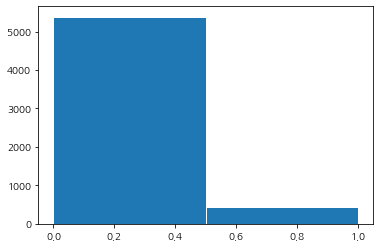

In [37]:
plt.hist(df['precipitation'], bins = 2, edgecolor = 'white')
plt.show()

6. 위 정보로 부터 파악한 내용 정리

- 보통은 비가 오지 않음. 비가 온 쪽의 데이터가 부족한 현상이 발생

7. 추가 분석사항 도출

- preperation이 1일때 대여량을 확인

### Feature4 : windspeed

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

풍속 (평균). 
- https://m.blog.naver.com/dhpyun/220697406626


- 보퍼트 풍력 계급 13단계
- 0등급 (0~0.2) : 연기가 위로 똑바로 올라가는 상태.
- 1등급 (0.3~1.5) : 연기가 날리나 바람개비에는 감지가 안됨.
- 2등급 (1.6~3.3) : 바람이 얼굴에 감촉. 나뭇잎이 흔들리며 바람개비에 감지.
- 3등급 (3.4~5.4) : 나뭇잎과 가는 가지가 쉴새없이 흔들림. 깃발이 가볍게 휘날림.
- 4등급 (5.5~7.9) : 먼지가 일고 종이조각이 날리며 작은 나뭇가지가 흔들림.
- 5등급 (8~10.7) : 작은 나무 전체가 흔들리고 강물에 잔물결.

2. 변수가 수치형인지 범주형인지


In [38]:
df['windspeed']

0       1.4
1       2.1
2       3.4
3       3.1
4       2.9
       ... 
5822    0.3
5823    2.0
5824    1.9
5825    2.1
5826    2.3
Name: windspeed, Length: 5827, dtype: float64

In [40]:
var = 'windspeed'
temp = df[var]
temp.unique()

array([1.4, 2.1, 3.4, 3.1, 2.9, 3. , 3.5, 4.3, 3.7, 3.2, 3.6, 2.4, 4.6,
       6.5, 5.7, 5.1, 4.8, 5. , 4. , 4.1, 4.9, 3.9, 2.8, 1.6, 0.9, 1.9,
       1.8, 2.3, 0.8, 2.5, 2.6, 2.2, 3.3, 5.4, 4.4, 4.5, 3.8, 1.7, 2.7,
       4.2, 2. , 1.5, 0.7, 0.4, 1. , 0.5, 1.2, 1.1, 1.3, 4.7, 0.6, 0.2,
       5.2, 6.1, 5.3, 6.7, 0. , 0.3, 5.5, 5.9, 6. , 8.3, 5.6, 6.6, 0.1,
       8.1, 6.9, 6.3, 5.8, 6.8, 6.4, 6.2])

3. 변수의 결측치 존재 여부 및 조치방안

In [41]:
df['windspeed'].isna().sum()

0

4. 변수의 기초 통계량 확인

In [43]:
df['windspeed'].describe()

count    5827.000000
mean        2.237601
std         1.054516
min         0.000000
25%         1.500000
50%         2.200000
75%         2.800000
max         8.300000
Name: windspeed, dtype: float64

5. 변수의 분포 확인

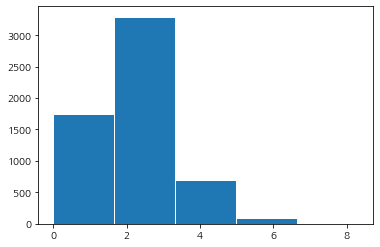

In [44]:
plt.hist(df['windspeed'], bins = 5, edgecolor = 'white')
plt.show()

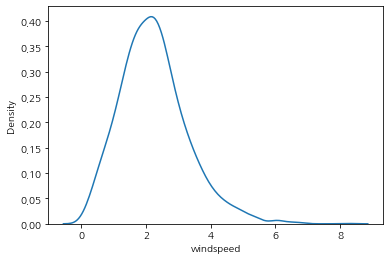

In [45]:
sns.kdeplot(df['windspeed'])
plt.show()

6. 위 정보로 부터 파악한 내용 정리

- 정규분포를 이룬다.
- 풍속이 2일때 (적당한 바람이 불때) 가 대체적으로 많음.

7. 추가 분석사항 도출

In [ ]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Feature5 : humidity

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

#### 습도를 의미.
- http://www.153weather.com/past_climate02.html


- 공기 중에 포함되어 있는 수증기의 비율
- 비율이기 때문에 최대 100%


- 대한민국의 평균 상대 습도는 67%
- 4월의 평균 습도는 59%, 7월의 평균 습도는 80%
- 여름 평균 습도는 76%
- 봄과 겨울 평균 습도는 63%, 62%

2. 변수가 수치형인지 범주형인지

In [46]:
df['humidity']

0       49
1       53
2       43
3       44
4       44
        ..
5822    66
5823    70
5824    70
5825    71
5826    71
Name: humidity, Length: 5827, dtype: int64

3. 변수의 결측치 존재 여부 및 조치방안

In [47]:
df['humidity'].isna().sum()

0

4. 변수의 기초 통계량 확인

In [48]:
df['humidity'].describe()

count    5827.000000
mean       68.608718
std        17.277266
min        19.000000
25%        56.000000
50%        70.000000
75%        82.000000
max       100.000000
Name: humidity, dtype: float64

5. 변수의 분포 확인

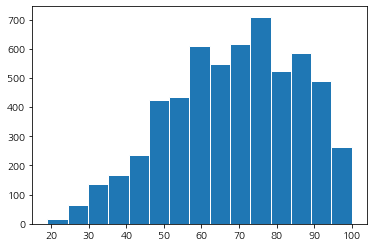

In [49]:
plt.hist(df['humidity'], bins = 15, edgecolor = 'white')
plt.show()

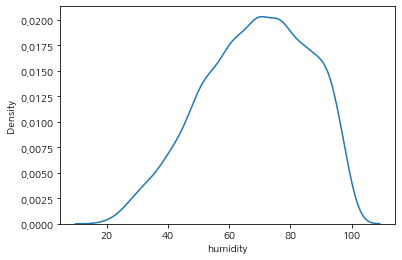

In [50]:
sns.kdeplot(df['humidity'])
plt.show()

6. 위 정보로 부터 파악한 내용 정리

- 서울의 습도 편차는 59 ~ 80.
    - 단, 위에서 조사한 것은 평균 상대 습도. (df의 기준과 일치하는지는 미지수)

7. 추가 분석사항 도출

- 대한민국의 평균 습도인 67%를 넘어갔을 때 따릉이 대여량의 관계가 궁금

In [52]:
hum = df.loc[df['humidity'] >= 67]
hum

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
57,2021-04-03,10,49.0,18.0,0.026,16.8,1,1.9,79,521,5
58,2021-04-03,11,45.0,15.0,0.018,15.8,1,2.2,89,206,1
59,2021-04-03,12,40.0,13.0,0.021,14.9,1,2.9,94,165,2
60,2021-04-03,13,20.0,9.0,0.021,14.8,1,2.1,94,386,2
61,2021-04-03,14,17.0,10.0,0.017,14.5,1,3.7,96,285,3
...,...,...,...,...,...,...,...,...,...,...,...
5809,2021-11-29,7,40.0,30.0,0.002,2.9,0,2.1,68,1910,157
5823,2021-11-29,21,65.0,56.0,0.002,8.4,0,2.0,70,1233,228
5824,2021-11-29,22,51.0,41.0,0.002,8.6,0,1.9,70,1250,215
5825,2021-11-29,23,43.0,35.0,0.001,8.2,0,2.1,71,1262,125


In [53]:
spst.pearsonr(hum['humidity'], hum['count'])

(-0.3772882414227592, 4.976014036971341e-112)

### Feature6 : visibility

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

#### 시정, 시계 (특정 기상 상태에 따른 가시성을 의미)

- 물체나 빛이 분명하게 보이는 최대 거리 (가시거리)
- 공기의 혼탁한 정도.
- 5km 미만의 시정은 m단위를 사용한다.

2. 변수가 수치형인지 범주형인지

In [54]:
df['visibility']

0       2000
1       2000
2       2000
3       2000
4       2000
        ... 
5822    1193
5823    1233
5824    1250
5825    1262
5826    1483
Name: visibility, Length: 5827, dtype: int64

3. 변수의 결측치 존재 여부 및 조치방안

In [55]:
df['visibility'].isna().sum()

0

4. 변수의 기초 통계량 확인

In [56]:
df['visibility'].describe()

count    5827.000000
mean     1758.438648
std       490.969394
min        60.000000
25%      1935.500000
50%      2000.000000
75%      2000.000000
max      2000.000000
Name: visibility, dtype: float64

5. 변수의 분포 확인

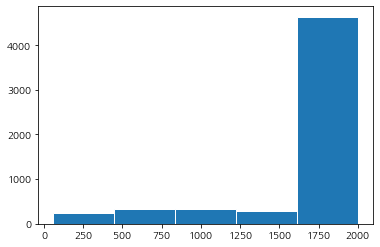

In [57]:
plt.hist(df['visibility'], bins = 5, edgecolor = 'white')
plt.show()

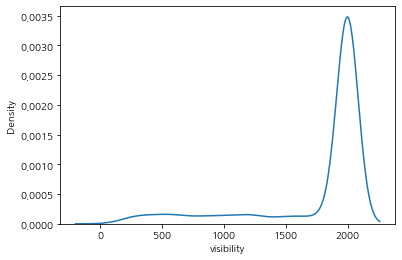

In [58]:
sns.kdeplot(df['visibility'])
plt.show()

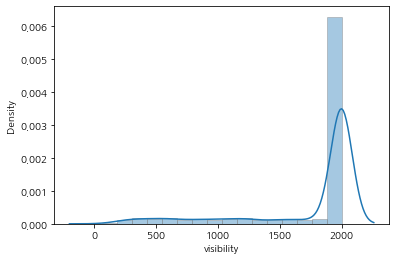

In [59]:
sns.distplot(df['visibility'], bins = 16, hist_kws = dict(edgecolor='grey'))
plt.show()

6. 위 정보로 부터 파악한 내용 정리

- 대체로 시정거리가 2000m임을 볼 수 있음.

7. 추가 분석사항 도출

- 월별 가시거리 여부가 궁금
- 미세먼지/초미세먼지와 시정간 관계는?

### Feature7 : ozone

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

#### 오존 수치

- https://science.ytn.co.kr/program/program_view.php?s_mcd=0082&s_hcd=0024&key=202007141654519393

- 서울의 오존 일평균은 0.031
- 기온 25도 이상, 상대습도 75% 이하, 풍속, 초속 4m 이하의 조건이면 급격히 늘어남.

2. 변수가 수치형인지 범주형인지

In [60]:
df['ozone']

0       0.002
1       0.003
2       0.023
3       0.028
4       0.008
        ...  
5822    0.002
5823    0.002
5824    0.002
5825    0.001
5826    0.004
Name: ozone, Length: 5827, dtype: float64

3. 변수의 결측치 존재 여부 및 조치방안

In [61]:
# 결측치가 존재
df['ozone'].isna().sum()

128

In [62]:
# 데이터 5827행 중 128개를 삭제할 수는 없음.
## 데이터가 오른쪽으로 치우쳐진 관계로 평균값 대체도 어렵다 판단.
### interpolate  사용
df['ozone'] = df['ozone'].interpolate(method='linear') # default는 linear
df['ozone'].isnull().sum()

0

4. 변수의 기초 통계량 확인

In [63]:
df['ozone'].describe()

count    5827.000000
mean        0.031634
std         0.018263
min         0.001000
25%         0.019000
50%         0.030000
75%         0.041000
max         0.137000
Name: ozone, dtype: float64

5. 변수의 분포 확인

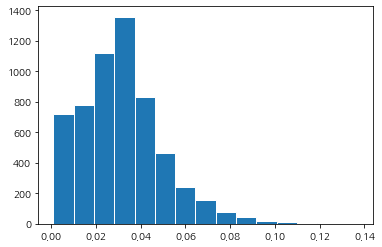

In [64]:
plt.hist(df['ozone'], bins = 15, edgecolor = 'white')
plt.show()

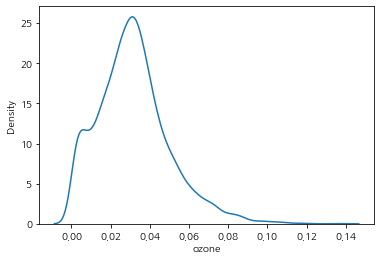

In [65]:
sns.kdeplot(df['ozone'])
plt.show()

6. 위 정보로 부터 파악한 내용 정리

- 서울의 오존 평균은 0.031. 평균적으로 크게 이 수치에서 벗어나지 않은 것 같음.

7. 추가 분석사항 도출

In [66]:
# 오존과 기온의 상관관계
spst.pearsonr(df['temperature'], df['ozone'])

(0.5369351933122658, 0.0)

In [67]:
# 오존과 습도의 상관관계
spst.pearsonr(df['humidity'], df['ozone'])

(-0.40709994117487325, 1.637569112065626e-231)

In [68]:
# 오존과 풍속의 상관관계
spst.pearsonr(df['windspeed'], df['ozone'])

(0.34040462536431904, 5.097253142855172e-158)

### Feature8 : PM10

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

#### 미세먼지 수치 (머리카락 굵기의 1/5 ~ 1/7 크기의 미세먼지)

- 서울 평균 미세먼지 수치는 35 (마포구는 31)
- 미세먼지는 입자의 크기가 10㎛ (밀리그램) 이하인 먼지.
- 초미세먼지는 입자의 크기가 2.5㎛ 이하인 먼지.

2. 변수가 수치형인지 범주형인지

In [69]:
df['PM10']

0       42.0
1       41.0
2       30.0
3       27.0
4       29.0
        ... 
5822    74.0
5823    65.0
5824    51.0
5825    43.0
5826    39.0
Name: PM10, Length: 5827, dtype: float64

3. 변수의 결측치 존재 여부 및 조치방안

In [70]:
df['PM10'].isna().sum()

102

In [71]:
# 역시 interpolate 이용
df['PM10'] = df['PM10'].interpolate(method='linear') # default는 linear
df['PM10'].isnull().sum()

0

4. 변수의 기초 통계량 확인

In [72]:
df['PM10'].describe()

count    5827.000000
mean       31.833705
std        42.650908
min         3.000000
25%        16.000000
50%        25.000000
75%        37.000000
max       827.000000
Name: PM10, dtype: float64

5. 변수의 분포 확인

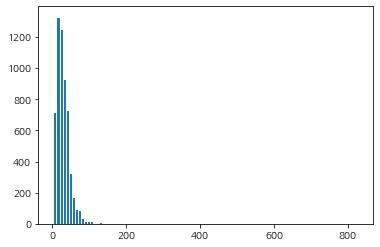

In [73]:
plt.hist(df['PM10'], bins = 100, edgecolor = 'white')
plt.show()

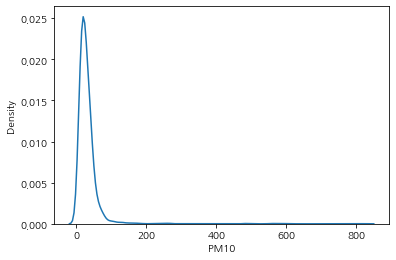

In [74]:
sns.kdeplot(df['PM10'])
plt.show()

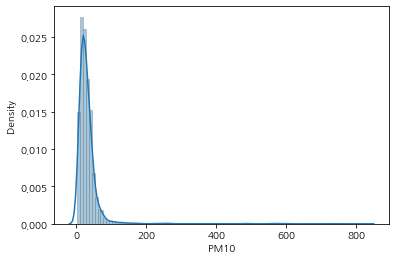

In [75]:
sns.distplot(df['PM10'], bins = 100, hist_kws = dict(edgecolor='grey'))
plt.show()

6. 위 정보로 부터 파악한 내용 정리

- 827이라는 값이 이상값은 아닐까?
- 몇백대의 값이 꽤 많음.

In [76]:
len(df.loc[df['PM10'] > 200])

44

In [77]:
df.loc[df['PM10'] > 200]

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
375,2021-04-16,16,269.0,62.0,0.037,14.7,0,4.1,61,1298,332
376,2021-04-16,17,296.0,57.0,0.034,14.6,0,3.9,46,1003,406
873,2021-05-07,12,309.0,47.0,0.029,15.2,0,5.2,62,955,184
874,2021-05-07,13,485.0,78.0,0.028,16.5,0,5.9,50,616,181
875,2021-05-07,14,562.0,88.0,0.029,16.6,0,6.1,50,490,207
876,2021-05-07,15,555.0,88.0,0.030,16.9,0,4.4,53,482,208
877,2021-05-07,16,563.0,89.0,0.027,16.8,0,5.0,55,499,265
878,2021-05-07,17,594.0,93.0,0.024,16.3,0,4.8,57,471,346
879,2021-05-07,18,606.0,94.0,0.020,15.4,0,3.9,63,444,537
880,2021-05-07,19,586.0,87.0,0.016,13.7,0,6.0,70,419,303


7. 추가 분석사항 도출

- 미세먼지 수치가 높을때는 주로 4월에서 5월임을 볼 수 있음
- 봄철 미세먼지 수치가 높을 때인가?

### Feature9 : PM2.5

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

#### 초미세먼지 수치 (머리카락 굵기의 1/20 ~ 1/30 크기의 미세먼지)

- 서울 평균 초미세먼지 수치는 19. (마포구는 18)
- 미세먼지는 입자의 크기가 10㎛ (밀리그램) 이하인 먼지.
- 초미세먼지는 입자의 크기가 2.5㎛ 이하인 먼지.

2. 변수가 수치형인지 범주형인지

In [78]:
df['PM2.5']

0       21.0
1       21.0
2       13.0
3       12.0
4       14.0
        ... 
5822    58.0
5823    56.0
5824    41.0
5825    35.0
5826    31.0
Name: PM2.5, Length: 5827, dtype: float64

3. 변수의 결측치 존재 여부 및 조치방안

In [79]:
df['PM2.5'].isna().sum()

95

In [80]:
# 역시 interpolate 이용
df['PM2.5'] = df['PM2.5'].interpolate(method='linear') # default는 linear
df['PM2.5'].isnull().sum()

0

4. 변수의 기초 통계량 확인

In [81]:
df['PM2.5'].describe()

count    5827.000000
mean       15.633774
std        13.791083
min         1.000000
25%         7.000000
50%        13.000000
75%        20.000000
max       125.000000
Name: PM2.5, dtype: float64

5. 변수의 분포 확인

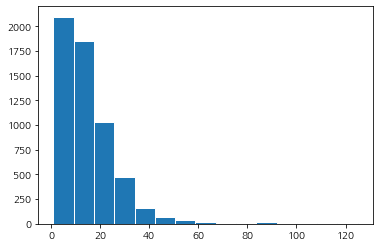

In [82]:
plt.hist(df['PM2.5'], bins = 15, edgecolor = 'white')
plt.show()

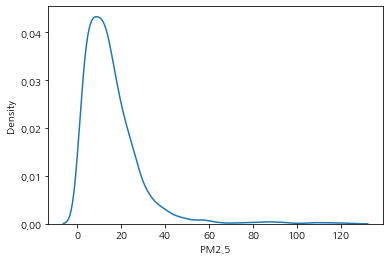

In [83]:
sns.kdeplot(df['PM2.5'])
plt.show()

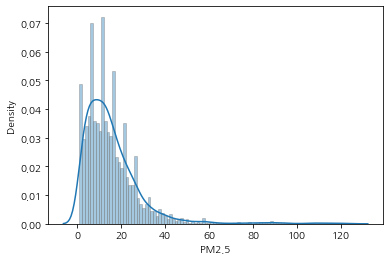

In [84]:
sns.distplot(df['PM2.5'], bins = 100, hist_kws = dict(edgecolor='grey'))
plt.show()

6. 위 정보로 부터 파악한 내용 정리

- 평균, 중앙값에 많이 분포해있다.
- 정규분포를 이룬다.

7. 추가 분석사항 도출

- 미세먼지가 높으면 초미세먼지가 높은지 궁금

In [85]:
spst.pearsonr(df['PM10'], df['PM2.5'])

(0.6841669416635532, 0.0)

- 미세먼지/초미세먼지와 가시거리의 관계가 궁금

In [87]:
spst.pearsonr(df['PM10'], df['visibility'])

(-0.28674542091350325, 1.079055454789358e-110)

In [88]:
spst.pearsonr(df['PM2.5'], df['visibility'])

(-0.43056537811926127, 1.0749338886685883e-261)

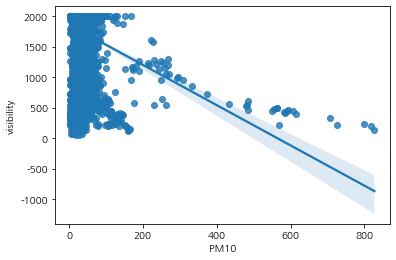

In [89]:
sns.regplot(x = 'PM10', y = 'visibility', data = df)
plt.show()

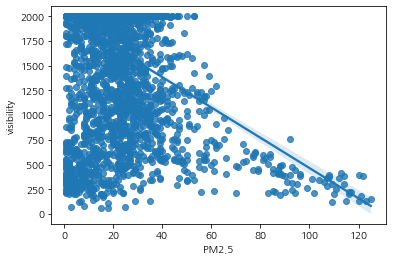

In [90]:
sns.regplot(x = 'PM2.5', y = 'visibility', data = df)
plt.show()

### Count (Target)

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

- 시간에 따른 따릉이 대여량 수

2. 변수가 수치형인지 범주형인지


In [91]:
df['count']

0        46
1        40
2        31
3        12
4        30
       ... 
5822    273
5823    228
5824    215
5825    125
5826     95
Name: count, Length: 5827, dtype: int64

In [92]:
var = 'count'
temp = df[var]
temp.unique()

array([  46,   40,   31,   12,   30,   77,  171,  330,  218,  175,  247,
        269,  289,  265,  342,  369,  564,  820,  526,  435,  396,  307,
        157,   85,   48,   17,   20,   24,   72,  169,  336,  207,  211,
        233,  286,  314,  360,  392,  507,  582,  411,  331,  366,  344,
        183,  126,   62,   58,   38,   18,   25,   43,   45,    5,    1,
          2,    3,    8,    6,   11,   15,   16,    7,   33,   67,   94,
        151,  210,  464,  601,  651,  613,  505,  427,  341,  252,  219,
        194,   78,   69,   35,    9,  188,  349,  187,  227,  280,  262,
        284,  390,  423,  552,  835,  479,  352,  258,  130,   80,   21,
         23,   29,  362,  230,  176,  249,  310,  268,  261,  329,  356,
        569,  856,  508,  413,  297,  112,   63,   36,   19,   28,   84,
        158,  216,  189,  282,  346,  274,  303,  324,  399,  574,  797,
        461,  293,  266,  103,   71,   42,  319,  140,  259,  492,  783,
        383,  276,  291,  108,   59,   60,   74,  1

3. 변수의 결측치 존재 여부 및 조치방안

In [93]:
df['count'].isna().sum()

0

4. 변수의 기초 통계량 확인

변수의 기초 통계량을 확인해보세요

In [94]:
df['count'].describe()

count    5827.000000
mean      215.117899
std       185.972900
min         1.000000
25%        53.000000
50%       186.000000
75%       315.000000
max      1746.000000
Name: count, dtype: float64

5. 변수의 분포 확인

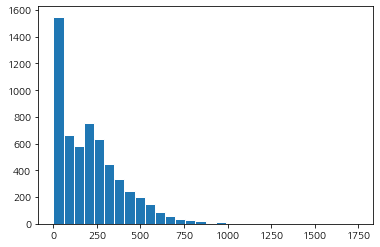

In [95]:
plt.hist(df['count'], bins = 30, edgecolor = 'white')
plt.show()

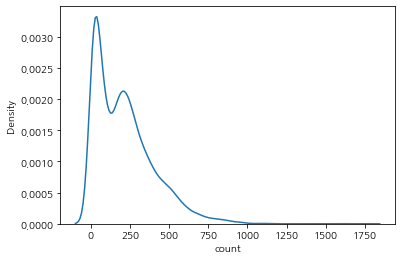

In [96]:
sns.kdeplot(df['count'])
plt.show()

<AxesSubplot:xlabel='count', ylabel='Density'>

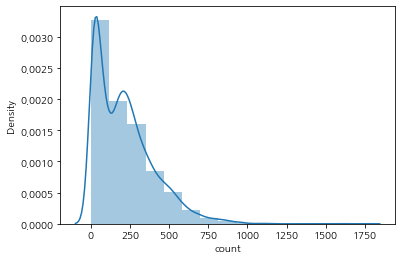

In [97]:
sns.distplot(df['count'], bins=15)

6. 위 정보로 부터 파악한 내용 정리

7. 추가 분석사항 도출

### 4.이변량 분석 
* 자료의 종류에 맞게 X --> Y 에 대해서 그래프(시각화)와 가설검정(수치화)를 수행하고 결과를 평가합니다.
* 가설검정시 다음의 항목을 참조하여 수행합니다.
    * 적절한 유의수준
    * 숫자 --> 숫자 : 상관분석
    * 범주 --> 범주 : 카이제곱검정
    * 범주 --> 숫자 : t검정, 분산분석
    * 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.

#### (1) 범주형 Feature --> 숫자형 Y (따릉이 대여 Count)

<font color="green">* 모든 범주형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.</font>


        1. 시각화 : 그래프를 활용한 데이터 분석
        2. 수치화 : t-test, anova
        3. 관계 평가 (가설 검정)

1. 강수 여부와 따릉이 대여량간 이변량 분석

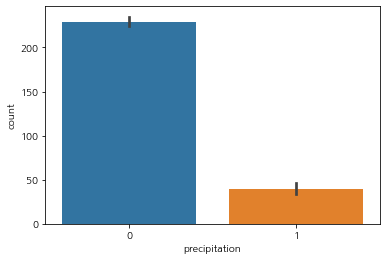

In [98]:
sns.barplot(x="precipitation", y="count", data=df)
plt.show()

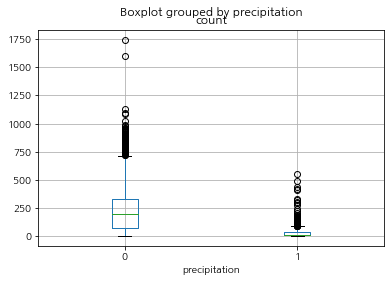

In [99]:
df.boxplot('count', 'precipitation')
plt.show()

2. 시간대별과 따릉이 대여량간 이변량 분석

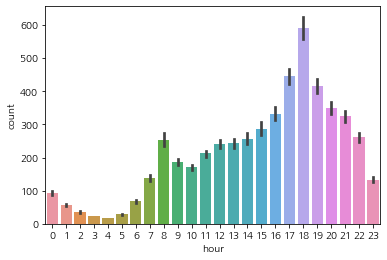

In [100]:
sns.barplot(x="hour", y="count", data=df)
plt.show()

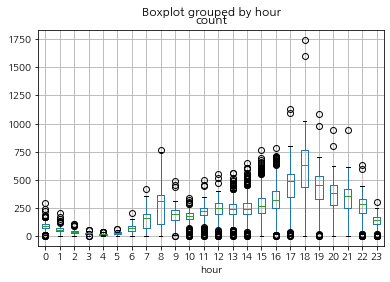

In [101]:
df.boxplot('count', 'hour')
plt.show()

#### (2) 숫자형 Feature --> 숫자형 Y (따릉이 대여 Count)

<font color="green">* 모든 숫자형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  </font>


        1. 시각화 : 그래프를 활용한 데이터 분석
        2. 수치화 : 상관분석
        3. 관계 평가 (가설 검정)

2. 시간대별 데이터와 따릉이 대여량간 분석

In [102]:
target = 'count'

#### 1) 시각화

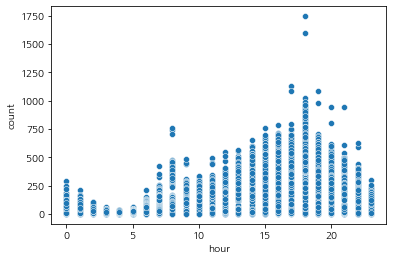

In [104]:
var = 'hour'

sns.scatterplot(x=var, y = target, data = df)
plt.show()

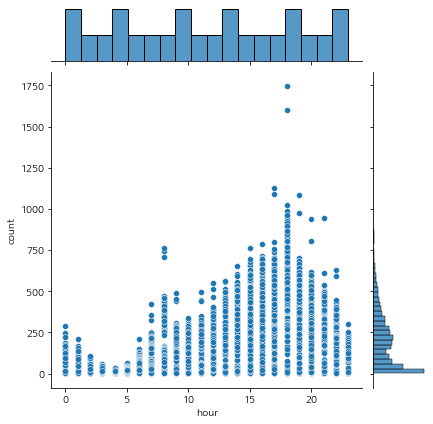

In [105]:
sns.jointplot(x=var, y = target, data = df)
plt.show()

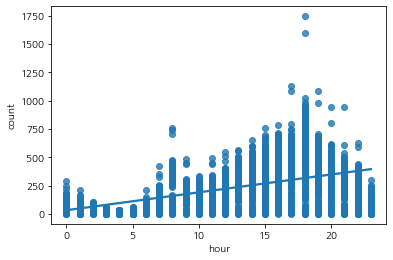

In [106]:
sns.regplot(x=var, y = target, data = df)
plt.show()

- 전체적으로 저녁 > 아침.
- 저녁 시간대 중에서는 퇴근 시간인 16시에 가장 대여량이 높음.
- 아침 시간대 중에서는 출근 시간인 08시에 가장 대여량이 높음.

#### 2) 수치화

In [186]:
result = spst.pearsonr(df_hour[var], df_hour[target])
print(f'상관계수 : {result[0]}, p-value : {result[1]}')

상관계수 : 0.7485955037152363, p-value : 2.582086180685308e-05


#### 3) 관계평가

상관계수가 0.75로 강한 연관성이 있다고 볼 수 있다. P-value는 5%의 유의수준보다 작으므로 대립가설이 맞다고 판단.  
따라서 시간대별과 따릉이 대여량은 높다고 볼 수 있다.

3. 온도 데이터와 따릉이 대여량간 분석

#### 1) 시각화

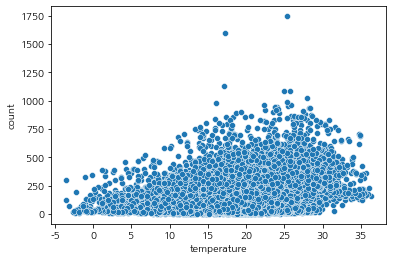

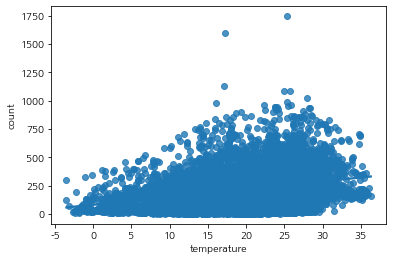

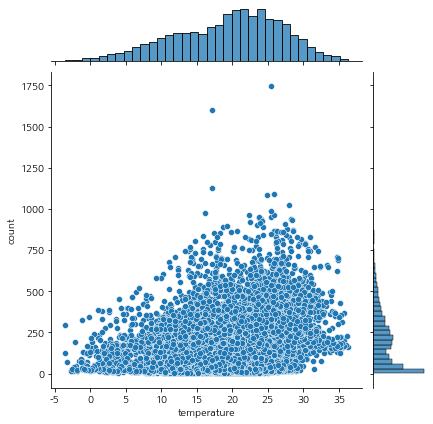

In [112]:
var = 'temperature'

sns.scatterplot(x=var, y = target, data = df)
plt.show()

sns.regplot(x=var, y = target, data = df)
plt.show()

sns.jointplot(x=var, y = target, data = df)
plt.show()

#### 2) 수치화

In [113]:
result = spst.pearsonr(df[var], df[target])
print(f'상관계수 : {result[0]}, p-value : {result[1]}')

상관계수 : 0.27716923630897916, p-value : 2.940516555163284e-103


#### 3) 관계평가
- 상관계수가 0.28로 약한 연관성이 있다고 볼 수 있다.  
- 평균기온일수록 대여량이 많을 줄 알았는데, 어느 정도는 맞는 말이지만 평균보다 낮거나 높다고 해서 대여량이 적은 것은 아니었다.

- 영하나 30도를 넘은 극한의 상황에서도 수요가 존재.
- 더울때보단 추울때 수요가 더 없음.

4. 풍속 데이터와 따릉이 대여량간 분석

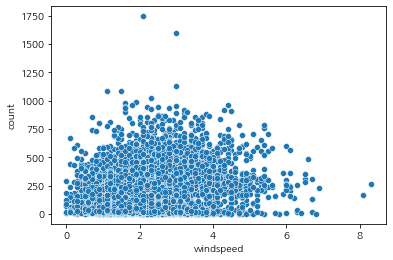

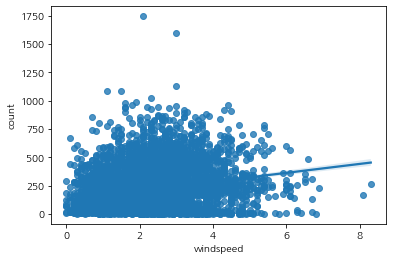

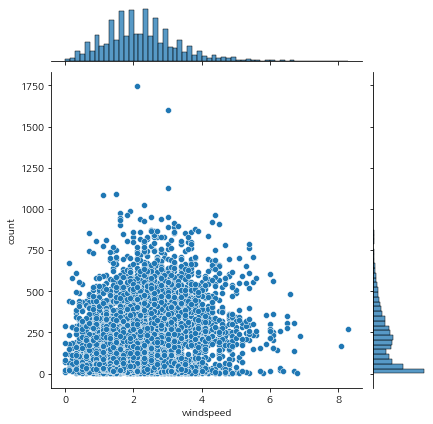

In [114]:
var = 'windspeed'

sns.scatterplot(x=var, y = target, data = df)
plt.show()

sns.regplot(x=var, y = target, data = df)
plt.show()

sns.jointplot(x=var, y = target, data = df)
plt.show()

In [115]:
result = spst.pearsonr(df[var], df[target])
print(f'상관계수 : {result[0]}, p-value : {result[1]}')

상관계수 : 0.22372189900674902, p-value : 5.243317678297076e-67


- 상관계수는 0.224로 약한 관계를 가진다.  
- P-value는 유의수준 5%보다 훨씬 작으므로 대립가설이 맞다고 판단.  
- 풍속과 대여량과의 관계가 클 것이라고 생각했으나, 생각보다 약한 관계성을 가진다는 것을 알았다.

- 바람 세기가 7 이상이면 수요가 거의 없음.
- 바람이 아주 세지만 않으면 항상 수요가 많다고 볼 수 있음.

5. 습도 데이터와 따릉이 대여량간 분석

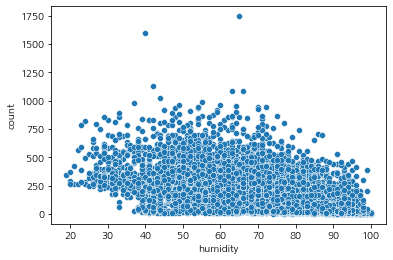

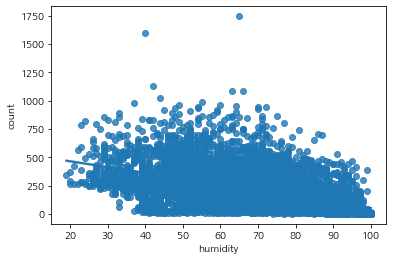

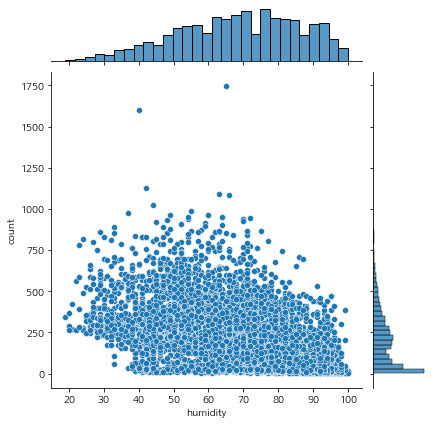

In [123]:
var = 'humidity'

sns.scatterplot(x=var, y = target, data = df)
plt.show()

sns.regplot(x=var, y = target, data = df)
plt.show()

sns.jointplot(x=var, y = target, data = df)
plt.show()

In [124]:
result = spst.pearsonr(df[var], df[target])
print(f'상관계수 : {result[0]}, p-value : {result[1]}')

상관계수 : -0.4789554265904139, p-value : 0.0


- 상관계수는 -0.479로 음의 상관관계를 가진다.

6. 시정 데이터와 따릉이 대여량간 분석

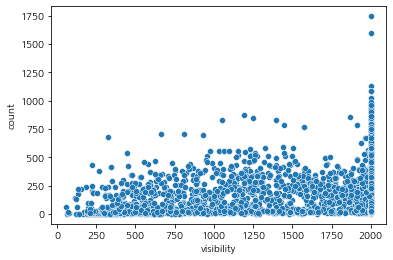

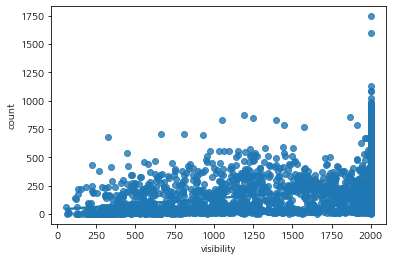

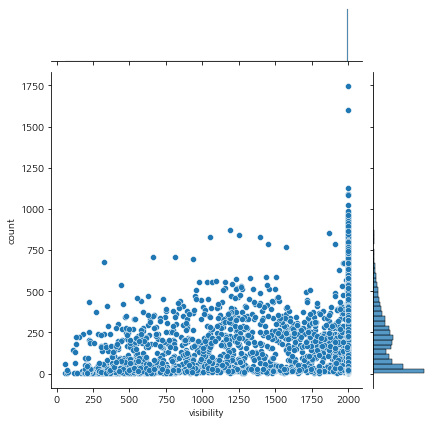

In [125]:
var = 'visibility'

sns.scatterplot(x=var, y = target, data = df)
plt.show()

sns.regplot(x=var, y = target, data = df)
plt.show()

sns.jointplot(x=var, y = target, data = df)
plt.show()

In [126]:
result = spst.pearsonr(df[var], df[target])
print(f'상관계수 : {result[0]}, p-value : {result[1]}')

상관계수 : 0.2658277832748897, p-value : 7.876003852878639e-95


- 시정거리가 2000m일때 확 늘어나는 것 이외에 수요는 꾸준함.
- 250 ~ 750 구간보다 1000 ~ 1500구간이 더 높긴 함.

7. 오존 데이터와 따릉이 대여량간 분석

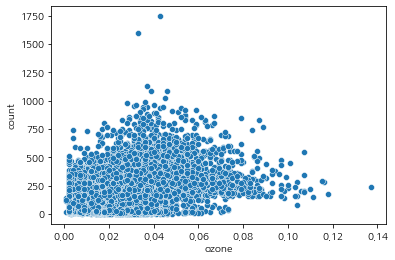

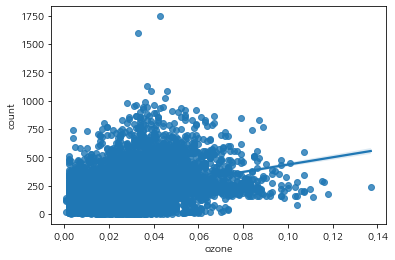

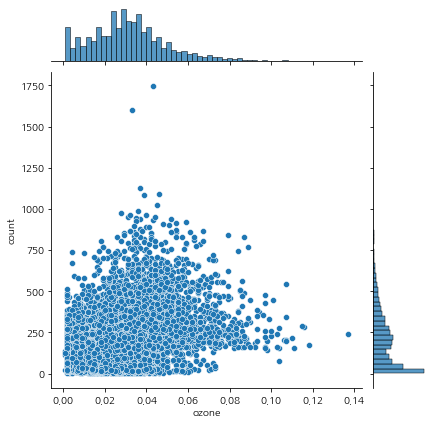

In [127]:
var = 'ozone'

sns.scatterplot(x=var, y = target, data = df)
plt.show()

sns.regplot(x=var, y = target, data = df)
plt.show()

sns.jointplot(x=var, y = target, data = df)
plt.show()

In [128]:
result = spst.pearsonr(df[var], df[target])
print(f'상관계수 : {result[0]}, p-value : {result[1]}')

상관계수 : 0.3179918655691491, p-value : 4.721727543199964e-137


8. 미세먼지 농도 데이터와 따릉이 대여량간 분석

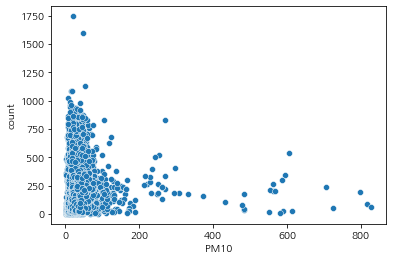

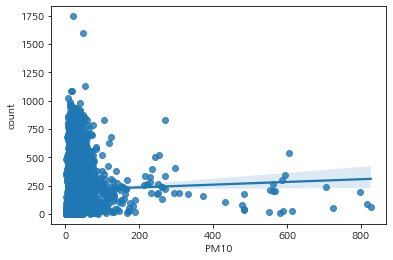

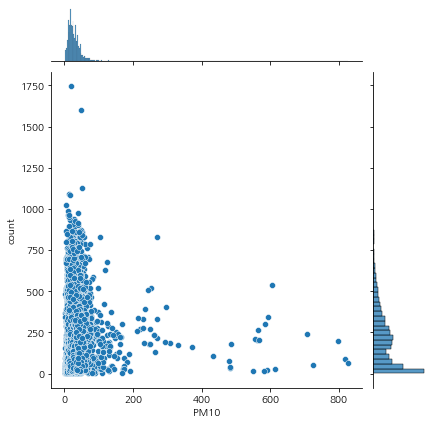

In [129]:
var = 'PM10'

sns.scatterplot(x=var, y = target, data = df)
plt.show()

sns.regplot(x=var, y = target, data = df)
plt.show()

sns.jointplot(x=var, y = target, data = df)
plt.show()

In [130]:
result = spst.pearsonr(df[var], df[target])
print(f'상관계수 : {result[0]}, p-value : {result[1]}')

상관계수 : 0.02753552779908246, p-value : 0.03556499262323277


9. 초미세먼지 농도 데이터와 따릉이 대여량간 분석

#### 1) 시각화

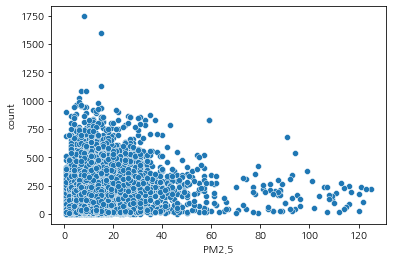

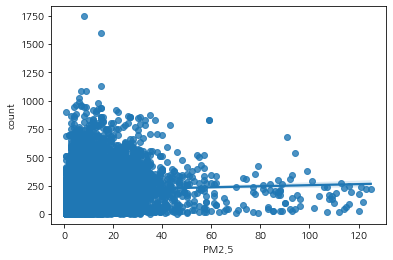

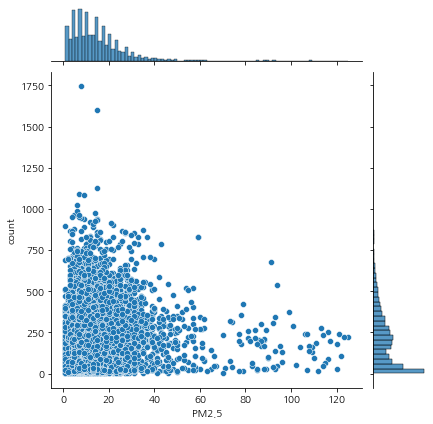

In [131]:
var = 'PM2.5'

sns.scatterplot(x=var, y = target, data = df)
plt.show()

sns.regplot(x=var, y = target, data = df)
plt.show()

sns.jointplot(x=var, y = target, data = df)
plt.show()

#### 2) 수치화

In [132]:
result = spst.pearsonr(df[var], df[target])
print(f'상관계수 : {result[0]}, p-value : {result[1]}')

상관계수 : 0.03483397779717591, p-value : 0.007830765224579699


In [120]:
df.sort_values('ozone', ascending=False).head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
2315,2021-07-06,15,59.0,38.0,0.137,29.7,0,3.5,56,1886,240
2865,2021-07-29,13,59.0,46.0,0.118,33.2,0,1.2,60,1590,174
1668,2021-06-09,16,57.0,35.0,0.116,31.3,0,3.0,38,2000,281
2316,2021-07-06,16,59.0,40.0,0.115,28.9,0,2.7,63,800,290
2843,2021-07-28,15,43.0,30.0,0.111,34.5,0,1.7,52,2000,154


In [122]:
df['ozone'].max()

0.137

#### 3) 관계평가

- 상관계수 : 0.0348, P-value : 0.0078  
- 낮은 상관계수를 갖기 때문에 연관성이 있다고 보기 어렵다.  
- 초미세먼지 수치가 높으면 대여량이 낮고, 수치가 낮을수록 대여량이 많을 것이라 생각했는데, 낮을수록 많은건 맞지만, 높다고 해서 대여량이 없는건 아니었다.

### 5. 가설 검정

#### <font color='green'>1. 강한 관계의 변수 (대립가설 채택)</font>

- precipitation (강우) (t검정 -88.266, 0.0)
- hour (시간) (0.586, 0.0)
- humidity (습도) (-0.479, 0.0)

#### <font color='green'>2. 약한 관계의 변수</font>


- temperature (온도) (0.277, 0.0)
- windspeed (풍속) (0.224, 0.0)
- visibility (시정) (0.266, 0.0)
- ozone (오존) (0.318, 0.0)

#### <font color='green'>3. 관계 없는 변수 (귀무가설 채택)</font>


- PM10 (미세먼지) (0.028. 0.036)
- PM2.5 (초미세먼지) (0.035, 0.008)

### 6. Insight 도출

- **가설 1 : 강우 여부 > 따릉이**
    - 강우가 -2보다 작은 음수이므로 강한 상관이 있다고 판단.


- **가설 2 : 미세먼지수치/초미세먼지수치 > 따릉이**
    - 사람들은 미세먼지 여부와 관련없이 따릉이를 대여한다.
    - 미세먼지는 비교적 영향을 미칠 것 같았는데 의외의 결과.
        - 미세먼지 > 시정 (-0.287, 0.0)
        - 초미세먼지 > 시정 (-0.431, 0.0)
        - 미세먼지도 약한 관계가 있으나, 초미세먼지가 가시거리와 관련이 큼을 알 수 있음.
        
        
- **가설 3 : 시정 > 따릉이**
    - 시정과 따릉이간에는 약한 양의 상관관계가 있음.
    - 미세/초미세먼지와 따릉이 간의 직접적은 관계는 없으나,
        - 미세/초미세 > 시정 > 따릉이 간의 관계는 어느 정도 존재한다고 판단.
        - 2020년 마스크 때문에 상관이 없다고 나온것 같습니다 / (미세먼지때문에) 시야가 안보이면 영향을 미친다(o)


- **가설 4 : 온도 > 따릉이**
    - 온도와 따릉이간에는 약한 양의 상관관계가 있음.
    - 온도와 습도의 상관관계는 어떨까?
        - 온도 > 습도 (-0.092, 0.0)
        - 해당 데이터에서 온도와 습도는 상관이 없는 모양.


- **가설 5 : 풍속 > 따릉이**
    - 풍속과 따릉이간에는 약한 양의 상관관계가 있음.


- **가설 6 : 습도 > 따릉이**
    - 습도와 따릉이간에는 강한 음의 상관관계가 있음.
    - 습도가 높을수록 따릉이 대여는 줄어든다.
    - 습도가 67% 이상일때의 df > 따릉이 대여 (-0.377, 0.0)
        - 관계가 있으나 전체 데이터보다 상관계수가 줄어들었다.


- **가설 7 : 오존 > 따릉이**
    - 오존과 따릉이간에는 약한 양의 상관관계가 있음.
    - 오존과 기온, 습도, 풍속간의 관계
        - 오존 > 기온 (0.537, 0.0)
        - 오존 > 습도 (-0.407, 0.0)
        - 오존 > 풍속 (0.340, 0.0)